In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import seaborn as sns
import tqdm
import pickle 

%matplotlib inline

In [2]:
def aggregate_data(data_path,save_path,file_name):
    df_dict = {}
    for filename in glob.glob(data_path):
        file = pd.read_csv(filename).fillna(0)
        ind = filename.split('/')[1].split('.')[0]
        features = file.sum().add_suffix('_sum')
        features = features.append(file.mean().add_suffix('_mean'))
        features = features.append(file.std().add_suffix('_std'))
        features = features.append(file.max().add_suffix('_max'))
        features = features.append(file.min().add_suffix('_min'))
        features = features.append(file.skew().add_suffix('_skew'))
        features = features.append(file.kurtosis().add_suffix('_kurtosis'))
        df_dict[ind] = features
    df = pd.DataFrame(df_dict).transpose()
    df.to_csv(save_path+file_name)

def quantile_data(data_path,save_path,file_name):
    df_dict = {}
    for filename in tqdm.tqdm(list(glob.glob(data_path))):
        file = pd.read_csv(filename).fillna(0)
        ind = filename.split('/')[1].split('.')[0]
        features = file.quantile(.8).add_suffix('_0.8')
        features = features.append(file.quantile(.9).add_suffix('_0.9'))
        features = features.append(file.quantile(.99).add_suffix('_0.99'))   
        df_dict[ind] = features
    df = pd.DataFrame(df_dict).transpose()
    df.to_csv(save_path+file_name)
    

def split_train_test_with_sklearn(df):  
    train, test  = train_test_split(df,test_size=0.33,random_state=42)
    return train, test

def prepare_for_modeling(df):
    y = df['time_to_eruption']
    #y = pd.factorize(y)[0]
    X = df.drop(['time_to_eruption'],axis=1)
    return X,y

https://www.kaggle.com/jesperdramsch/introduction-to-volcanology-seismograms-and-lgbm

http://eqseis.geosc.psu.edu/cammon/HTML/Classes/IntroQuakes/Notes/seismometers.html

   segment_id  time_to_eruption
0  1136037770          12262005
1  1969647810          32739612
2  1895879680          14965999
3  2068207140          26469720
4   192955606          31072429


Text(0, 0.5, 'count')

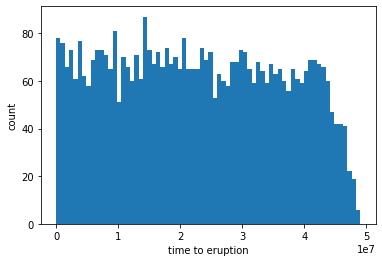

In [3]:
time = pd.read_csv('train.csv')
print(time.head())
plt.hist(time['time_to_eruption'],70)
plt.xlabel('time to eruption')
plt.ylabel('count')

Text(0, 0.5, 'time')

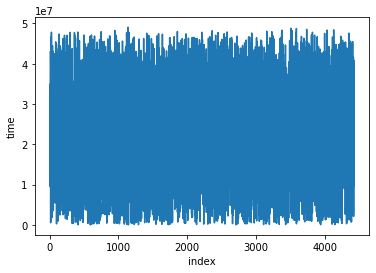

In [4]:
time['time_to_eruption'].plot()
plt.xlabel('index')
plt.ylabel('time')

In [5]:
time.describe()

,segment_id,time_to_eruption
count,4.431000e+03,4.431000e+03
mean,1.074694e+09,2.284891e+07
std,6.161966e+08,1.348439e+07
min,5.131810e+05,6.250000e+03
25%,5.527934e+08,1.127016e+07
50%,1.066153e+09,2.246559e+07
75%,1.606350e+09,3.434356e+07
max,2.146939e+09,4.904609e+07


In [6]:
print('Median: {}'.format(time['time_to_eruption'].median()))
print('Mean: {}'.format(time['time_to_eruption'].mean()))
print('Max: {}'.format(time['time_to_eruption'].max()))
print('Min: {}'.format(time['time_to_eruption'].min()))
print('Std: {}'.format(time['time_to_eruption'].std()))
print('Kurtosis: {}'.format(time['time_to_eruption'].kurtosis()))

Median: 22465586.0
Mean: 22848906.832769126
Max: 49046087
Min: 6250
Std: 13484385.863632679
Kurtosis: -1.166601027916375


Text(0, 0.5, 'time to eruption')

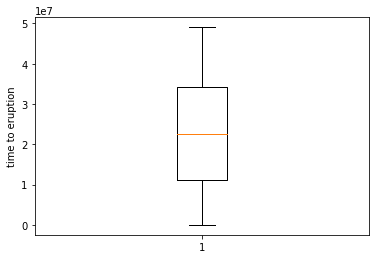

In [7]:
plt.boxplot(time['time_to_eruption'])
plt.ylabel('time to eruption')

In [8]:
df_sample = pd.read_csv('train/1000015382.csv')
#df_sample = df_sample.fillna(0)
df_sample.describe()


,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10
count,60001.000000,59847.000000,60001.000000,60001.000000,60001.000000,60001.000000,60001.000000,60001.000000,60001.000000,60001.000000
mean,0.382244,2.266563,2.192213,-0.148031,-0.263129,1.630089,-0.615190,-0.177964,-0.402777,0.896752
std,111.553322,451.741111,373.923764,231.812464,129.504432,222.294642,269.678045,319.999406,176.087814,249.024286
min,-920.000000,-7871.000000,-2444.000000,-1815.000000,-2484.000000,-1128.000000,-1453.000000,-2947.000000,-1585.000000,-2961.000000
25%,-66.000000,-163.000000,-223.000000,-150.000000,-30.000000,-147.000000,-172.000000,-194.000000,-106.000000,-117.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,67.000000,168.000000,224.000000,149.000000,30.000000,149.000000,174.000000,195.000000,106.000000,119.000000
max,822.000000,7321.000000,2563.000000,1491.000000,2608.000000,1119.000000,1668.000000,3676.000000,1162.000000,3179.000000


In [9]:
len(df_sample)

60001

We see that we have 10 sensors and 60001 observation. In sensor_2 we have NULL values, which we need to set to 0

In [10]:
df_sample = df_sample.fillna(0)
df_sample.describe()

,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10
count,60001.000000,60001.000000,60001.000000,60001.000000,60001.000000,60001.000000,60001.000000,60001.000000,60001.000000,60001.000000
mean,0.382244,2.260746,2.192213,-0.148031,-0.263129,1.630089,-0.615190,-0.177964,-0.402777,0.896752
std,111.553322,451.161018,373.923764,231.812464,129.504432,222.294642,269.678045,319.999406,176.087814,249.024286
min,-920.000000,-7871.000000,-2444.000000,-1815.000000,-2484.000000,-1128.000000,-1453.000000,-2947.000000,-1585.000000,-2961.000000
25%,-66.000000,-163.000000,-223.000000,-150.000000,-30.000000,-147.000000,-172.000000,-194.000000,-106.000000,-117.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,67.000000,167.000000,224.000000,149.000000,30.000000,149.000000,174.000000,195.000000,106.000000,119.000000
max,822.000000,7321.000000,2563.000000,1491.000000,2608.000000,1119.000000,1668.000000,3676.000000,1162.000000,3179.000000


In [11]:
time[time['segment_id']==1000015382]

,segment_id,time_to_eruption
1901,1000015382,16258654


Now we fill null with zero

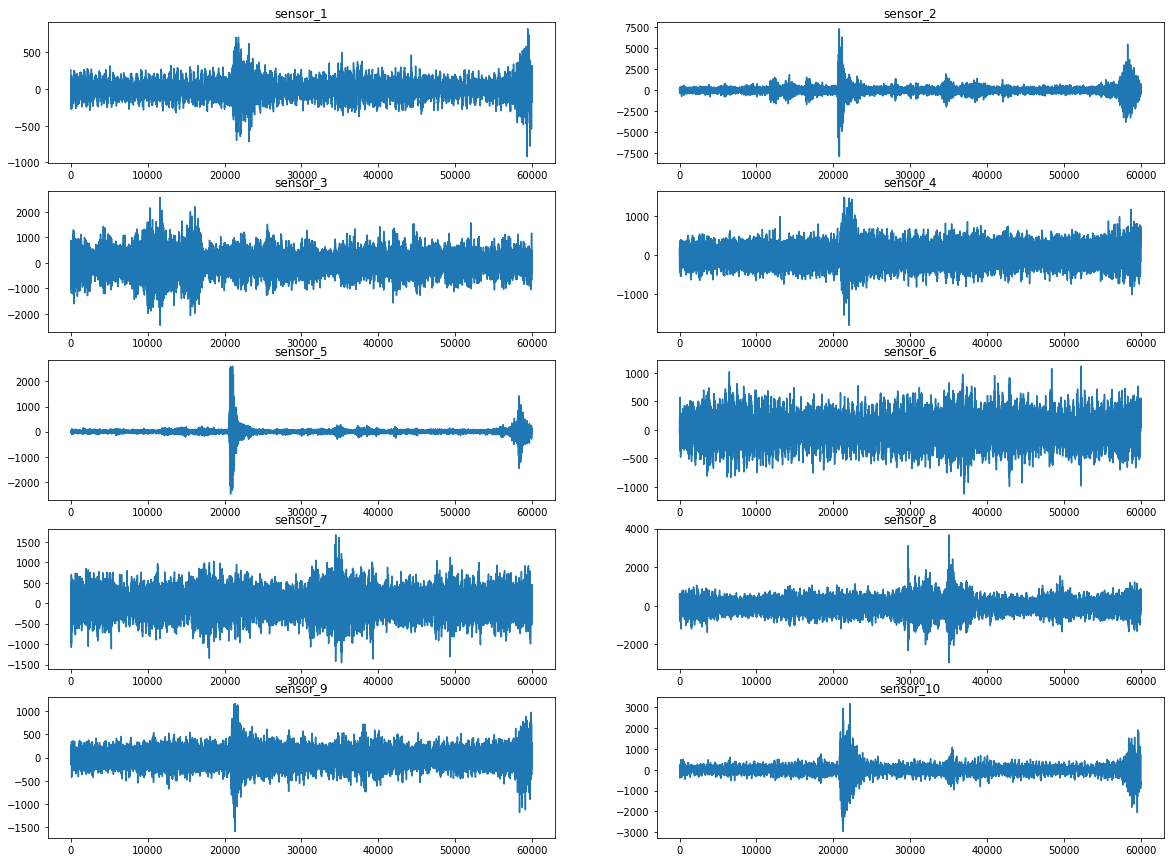

In [12]:
plt.figure(figsize=(20,15))
for i,col in enumerate(df_sample.columns):
    plt.subplot(5,2,i+1)
    plt.plot(df_sample[col])
    #plt.plot([10000,10000],[])
    plt.title(col)

In [13]:
train_files = glob.glob('train/*.csv')
print('Number of train files {}'.format(len(train_files)))

Number of train files 4432


In [ ]:
#aggregate_data('train/*.csv','train/','aggredated_train.csv')
#aggregate_data('test/*.csv','test/','aggredated_test.csv')

#quantile_data('train/*.csv','train/','quantiled_train.csv')
#quantile_data('test/*.csv','test/','quantiled_test.csv')

(array([0., 0., 0., 0., 0., 0., 0.]),
 array([0.        , 0.14285714, 0.28571429, 0.42857143, 0.57142857,
        0.71428571, 0.85714286, 1.        ]),
 <a list of 7 Patch objects>)

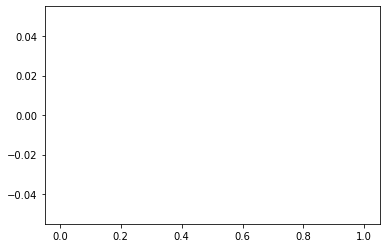

In [126]:
plt.hist(df.isnull().sum()[df.isnull().sum()>0].sort_values(),7)

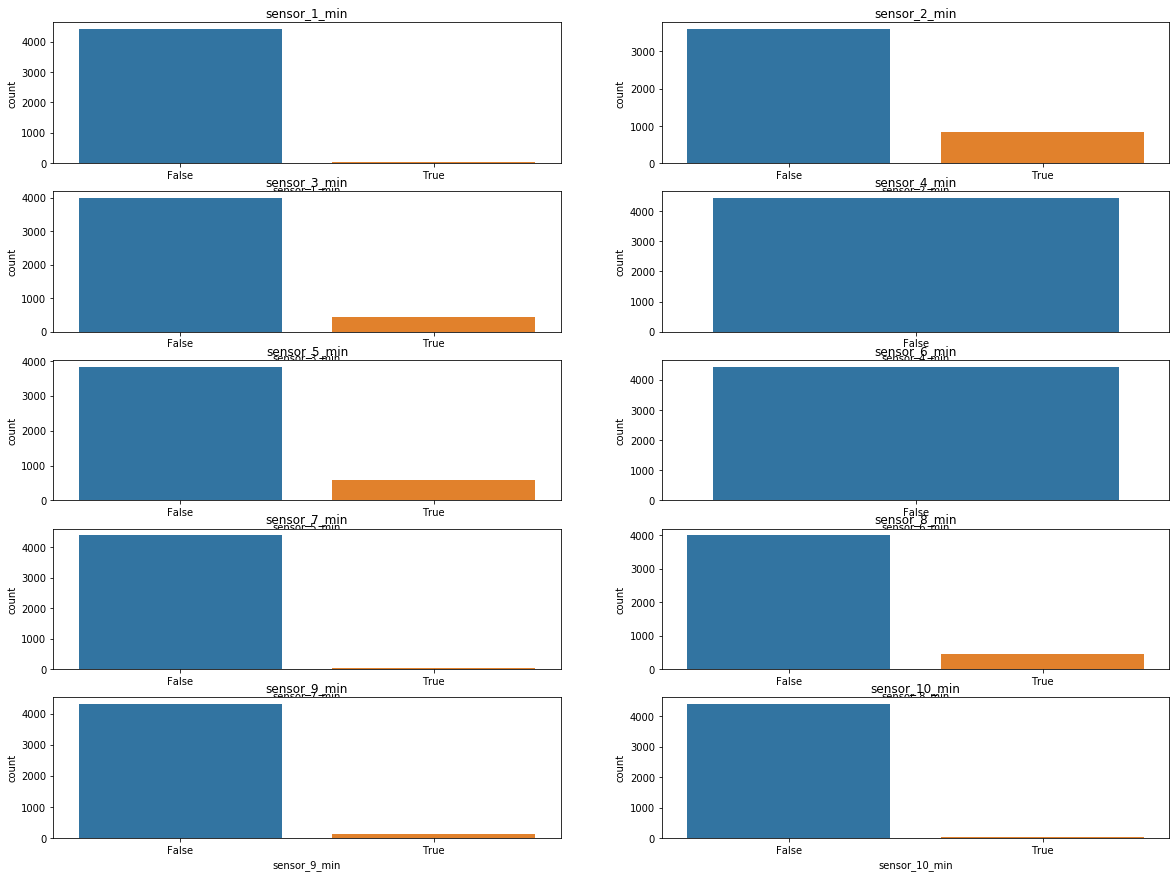

In [113]:
# number of NaN before function aggregate_data(data_path,save_path,file_name) fill NaN was done 

plt.figure(figsize=(20,15))
for num in range(1,11):
    plt.subplot(5,2,num)
    l = df['sensor_{}_{}'.format(num,'min')]
    l = pd.DataFrame(l.isnull())
    ax = sns.countplot(x='sensor_{}_{}'.format(num,'min'), data=l)
    plt.title('sensor_{}_{}'.format(num,'min'))

In [ ]:
#load data and merge to o
df1 = pd.read_csv('aggredated_train.csv')
df2 = pd.read_csv('train/quantiled_train.csv')
df1 = df1.rename(columns = {'Unnamed: 0':'segment_id'}) 
df2 = df2.rename(columns = {'Unnamed: 0':'segment_id'})# 'segment_id' object-> float64
df = pd.merge(time,df1, on=['segment_id'])
df = pd.merge(df,df2,on='segment_id')
df = df.set_index('segment_id')

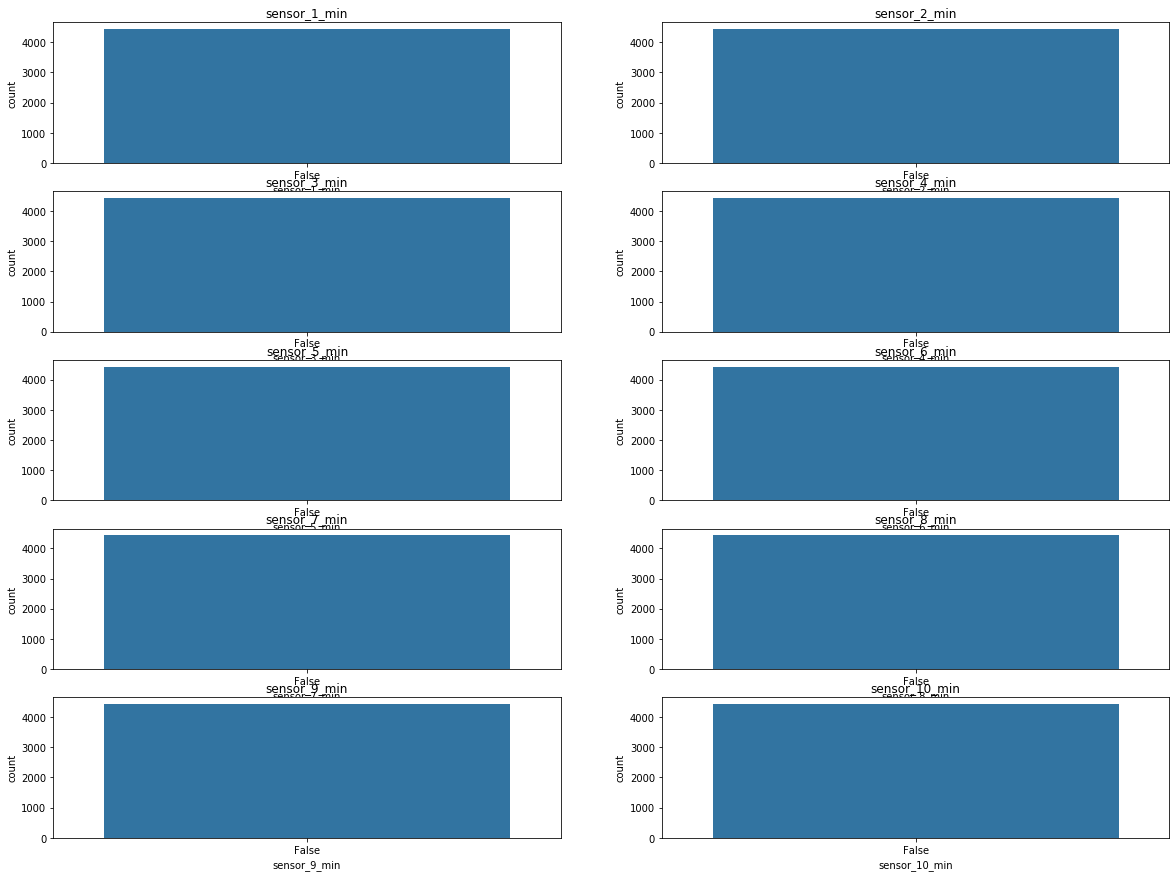

In [19]:

import seaborn as sns
plt.figure(figsize=(20,15))
for num in range(1,11):
    plt.subplot(5,2,num)
    l = df['sensor_{}_{}'.format(num,'min')]
    l = pd.DataFrame(l.isnull())
    ax = sns.countplot(x='sensor_{}_{}'.format(num,'min'), data=l)
    plt.title('sensor_{}_{}'.format(num,'min'))

In [376]:
# split train/test
#df_x = pd.merge(time,df2, on=['segment_id'])
#df_x = df_x.set_index('segment_id')

train,test = split_train_test_with_sklearn(df)
print('Train shape is {}, test size is {}'.format(train.shape,test.shape))

X_train,y_train = prepare_for_modeling(train)
X_test,y_test = prepare_for_modeling(test)

lin_reg = LinearRegression()
lin_reg.fit(X_train,y_train)
y_pred = lin_reg.predict(X_test)
MSA = mean_absolute_error(y_test,y_pred)
print('Linear Regression MSA: {}'.format(MSA))

lasso = Lasso(alpha = 0.5)
lasso.fit(X_train,y_train)
y_pred = lasso.predict(X_test)
MSA = mean_absolute_error(y_test,y_pred)
print('Lasso MSA: {}'.format(MSA))

dec_tree = DecisionTreeRegressor()
dec_tree.fit(X_train,y_train)
y_pred = dec_tree.predict(X_test)
MSA = mean_absolute_error(y_test,y_pred)
print('Decision Tree MSA: {}'.format(MSA))

ran_for = RandomForestRegressor()
ran_for.fit(X_train,y_train)
y_pred = ran_for.predict(X_test)
MSA = mean_absolute_error(y_test,y_pred)
print('Random Forest Regressor MSA: {}'.format(MSA))


Train shape is (2968, 101), test size is (1463, 101)
Linear Regression MSA: 10565361.322377482


/home/kasia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9927423749335677e+17, tolerance: 53098442976163.04
  positive)


Lasso MSA: 10577861.716455752
Decision Tree MSA: 5360968.803827751
Random Forest Regressor MSA: 4793052.638564593


In [375]:
#features importance

f = pd.DataFrame([X_train.columns,ran_for.feature_importances_]).T
f.columns = ['feature','value']
important_f = f.sort_values('value',ascending=False)[:50]
X_train = X_train.filter(items=list(important_f['feature']))
X_train

f = pd.DataFrame([X_train.columns,ran_for.feature_importances_]).T
f.columns = ['feature','value']
important_f = f.sort_values('value',ascending=False)[:50]
important_f
X_test = X_test.filter(items=list(important_f['feature']))
#important_f 
X_test 


ran_for = RandomForestRegressor()
ran_for.fit(X_test,y_test)
y_pred = ran_for.predict(X_test)
MSA = mean_absolute_error(y_test,y_pred)
print('Random Forest Regressor MSA: {}'.format(MSA))
test_f = ran_for.feature_importances_

,sensor_2_0.99,sensor_5_0.99,sensor_8_0.99,sensor_6_0.8,sensor_10_0.9,sensor_3_max,sensor_1_0.8,sensor_9_0.99,sensor_3_0.8,sensor_6_std,sensor_6_0.99,sensor_1_min,sensor_2_0.8,sensor_6_kurtosis,sensor_2_min,sensor_8_min,sensor_7_max,sensor_6_min,sensor_2_std,sensor_2_0.9
segment_id,,,,,,,,,,,,,,,,,,,,
412526212,2567.0,583.0,1075.0,2577.0,1006.0,1488.0,279.0,996.0,250.0,4188.622374,11145.0,-1643.0,455.0,3.419167,-12750.0,-2592.0,2641.0,-32767.0,864.491921,765.0
1086656455,1583.0,385.0,363.0,154.0,255.0,702.0,86.0,387.0,78.0,184.258608,439.0,-827.0,259.0,0.123493,-8141.0,-633.0,555.0,-707.0,599.687466,441.0
1731539296,1074.0,473.0,582.0,233.0,833.0,1001.0,219.0,667.0,192.0,279.154701,650.0,-1521.0,310.0,0.177674,-3120.0,-2459.0,5487.0,-1247.0,419.440680,492.0
1109804924,3781.0,711.0,1247.0,320.0,919.0,1710.0,317.0,1091.0,277.0,382.361546,902.0,-1724.0,926.0,0.572949,-12691.0,-5066.0,2063.0,-2600.0,1385.409621,1506.0
1869661089,1259.0,507.0,1378.0,399.0,984.0,1737.0,306.0,758.0,254.0,481.953127,1122.0,-1980.0,363.0,0.091187,-9079.0,-2180.0,2288.0,-1894.0,521.780310,563.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
873340274,2407.0,641.0,142.0,1318.0,1305.0,2335.0,518.0,1365.0,436.0,1575.602116,3594.0,-2610.0,696.0,-0.107407,-5989.0,-269.0,232.0,-5555.0,940.746578,1109.0
1099864364,1005.0,242.0,872.0,208.0,254.0,1264.0,94.0,371.0,360.0,254.954648,629.0,-680.0,209.0,0.502679,-5579.0,-8070.0,2849.0,-1287.0,384.535415,346.0
571683257,2375.0,490.0,3355.0,1568.0,1260.0,1767.0,551.0,1208.0,415.0,1931.895985,4604.0,-2139.0,644.0,0.312052,-9282.0,-4332.0,3423.0,-7338.0,910.997793,1030.0


In [235]:
from sklearn.model_selection import GridSearchCV


df_x = pd.merge(time,df2, on=['segment_id'])
df_x = df_x.set_index('segment_id')

train,test = split_train_test_with_sklearn(df_x)

X_train,y_train = prepare_for_modeling(train)
X_test,y_test = prepare_for_modeling(test)

param_grid = [{
    'n_estimators':[150],
    'max_depth':[15],
    'min_child_weight': [1],
    'subsample': [1],
    'colsample_bytree': [1],
    'learning_rate':[0.10],
    # Other parameters
    'objective':['reg:squarederror']}]


xgb_cl = xgb.XGBRegressor()
grid_search = GridSearchCV(xgb_cl,param_grid,cv=5, scoring = 'neg_mean_absolute_error')
grid_search.fit(X_train,y_train)

final_model = grid_search.best_estimator_
final_model = grid_search.best_estimator_
y_pred = final_model.predict(X_test)
MSA = mean_absolute_error(y_test,y_pred)
print('MSA: {}'.format(MSA))

MSA: 3761454.8834586465


In [388]:
#alternative for evaluation to train/test
X_df_cross,y_df_cross= prepare_for_modeling(df)
scores = cross_val_score(dec_tree,X_df_cross,y_df_cross,scoring='neg_mean_absolute_error',cv=5)
print('Mean MAE for cross val score is {}'.format((-scores).mean()))
print('Std for MAE for cross val score is {}'.format((-scores).std()))

Mean MAE for cross val score is 5205718.440907413
Std for MAE for cross val score is 265438.07336345967


In [239]:
# whole df train, df_test to predict
"""df_test = pd.read_csv('test/quantiled_test.csv')
df_test = df_test.rename(columns = {'Unnamed: 0':'segment_id'})
df_test = df_test.set_index('segment_id')
df_test"""



#df1_test = pd.read_csv('aggredated_test.csv')
df2_test = pd.read_csv('test/quantiled_test.csv')
#df1.head()
#df1_test = df1_test.rename(columns = {'Unnamed: 0':'segment_id'}) 
df2_test = df2_test.rename(columns = {'Unnamed: 0':'segment_id'})


#df_test = pd.merge(df1_test,df2_test,on='segment_id')
df_test = df2_test.set_index('segment_id')


X_df_all,y_df_all= prepare_for_modeling(df_x)
ran_for = final_model
ran_for.fit(X_df_all,y_df_all)
y_pred = ran_for.predict(df_test)


In [240]:
# results submission 
data = {'segment_id':df_test.index,
        'time_to_eruption':y_pred}
forsub = pd.DataFrame(data)
forsub = forsub.astype(int)
sub = pd.read_csv('sample_submission.csv')
sub = sub.drop('time_to_eruption',axis=1)
submission_file = pd.merge(sub,forsub, on='segment_id')
submission_file.to_csv('submission_file_XGB.csv')

array([[-2.00529221],
       [-2.16170494],
       [-2.8934187 ],
       [-2.36009274],
       [-2.56634777],
       [-2.10666413],
       [-2.94441573],
       [-2.92096782],
       [-2.4139359 ],
       [-2.1110459 ],
       [-2.56608441],
       [-2.90184576],
       [-2.66004612],
       [-2.41140421],
       [-2.54374286],
       [-2.91857817],
       [-2.14309255],
       [-2.7381242 ],
       [-2.41924611],
       [-2.4019224 ],
       [-2.42978545],
       [-2.05372968],
       [-2.71273189],
       [-2.60775417],
       [-2.42373999],
       [-2.42576981],
       [-2.11366233],
       [-2.90139117],
       [-2.60285048],
       [-2.55513806],
       [-2.10740307],
       [-2.41361023],
       [-2.58420498],
       [-2.60979128],
       [-2.90283576],
       [-2.54167234],
       [-2.95585428],
       [-2.62485469],
       [-2.29477923],
       [-2.36166277],
       [-2.79909819],
       [-2.97651167],
       [-2.79902131],
       [-2.15848943],
       [-2.4440226 ],
       [-2

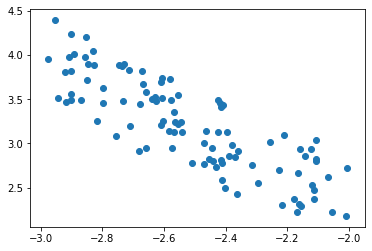

In [267]:
m = 100
X = np.random.rand(m,1)-3
y = 0.5*X**2+X+2+np.random.rand(m,1)
plt.scatter(X,y)
X

In [268]:
from sklearn.preprocessing import PolynomialFeatures
pol = PolynomialFeatures(degree=2,include_bias=False)
X_pol = pol.fit_transform(X)
lin_reg =LinearRegression()
lin_reg.fit(X_pol,y)
lin_reg.intercept_,lin_reg.coef_

#y1 = 0.95283399*X**2+0.95283399*X+0.95283399

(array([1.48879545]), array([[0.32596159, 0.39471295]]))

In [281]:
X_pol[:,0]

array([-2.00529221, -2.16170494, -2.8934187 , -2.36009274, -2.56634777,
       -2.10666413, -2.94441573, -2.92096782, -2.4139359 , -2.1110459 ,
       -2.56608441, -2.90184576, -2.66004612, -2.41140421, -2.54374286,
       -2.91857817, -2.14309255, -2.7381242 , -2.41924611, -2.4019224 ,
       -2.42978545, -2.05372968, -2.71273189, -2.60775417, -2.42373999,
       -2.42576981, -2.11366233, -2.90139117, -2.60285048, -2.55513806,
       -2.10740307, -2.41361023, -2.58420498, -2.60979128, -2.90283576,
       -2.54167234, -2.95585428, -2.62485469, -2.29477923, -2.36166277,
       -2.79909819, -2.97651167, -2.79902131, -2.15848943, -2.4440226 ,
       -2.85325158, -2.11804989, -2.71015846, -2.67224285, -2.1791669 ,
       -2.16827023, -2.74517251, -2.87075674, -2.67871821, -2.40910219,
       -2.61011694, -2.50773145, -2.44149002, -2.554802  , -2.57309634,
       -2.15560312, -2.83043276, -2.63799071, -2.20973758, -2.1644162 ,
       -2.81623822, -2.22552359, -2.68060699, -2.90332765, -2.36

best submission was XGBoost with file only with quantile
Leaderboard position 196